# Assignment 1

## Step 1: Uploading and inspecting the data

* `head()` for getting a first few rows of the dataset, looking at the kind of values
* `info()` for getting the description of the data columns
* `value_counts()` for counting the instances of each value in categorical variable (maybe would work for floating-point but results would be rather meaningless).
* `describe()` for per-feature summary statistics

*Questions on interpretation of the dataset from* `describe()`:
1. *Interpreting the values.* Not sure what is meant there. The method just returns per-column (feature) summary statistics.
2. *Meaning of percentiles.* Percentiles tell how much the distribution is skewed based on how far away the median is from each of the quartiles—`households` column is one such example where distribution is skewed to the left (or tail-heavy?).
3. *Handling of missing values.* Documentation says `NaN` by default, which would be skipped in computing statistics (`skipna=True` by default) but would be kept in arrays and propagate through arithmetic calculations. When all values are `NaN` result in automatic statistic calculation is 0.

## Step 2: Splitting the data into training and test sets

* `np.random.permutation(len(data))` for shuffling the indices and then taking `test_indices` and `train_indices` from this accordingly;
  * `data.iloc[train_indices]` for retrieving the data
* `from sklearn.model_selection import train_test_split` for automatically splitting the dataset by describing the fraction of test data
* stratified sampling to get similar train and test distributions if some features are imbalanced—both distributions will be more representative
* binning to limit the number of strata
  * `from sklearn.model_selection import StratifiedShuffleSplit`
  * split based on a categorical attribute: `split.split(df, df["attr"])`
  
## Step 3: Exploring the attributes

* Visualisation to 
  * see most informative attributes 
  * observe correlations with target label using scatter matrix
  * observe the need for normalisation/scaling
  * can also indicate the artifacts in the data that would need cleaning up
* Create extra features

## Step 4: Data preparation and transformations of machine learning algorithms

Required for:
* handling missing values (if any)
  * `from sklearn.impute import SimpleImputer`, `imputer.fit(df)`, `imputer.transform`
* converting attribute values into numerical format (e.g. transform categorical data into numbers)—*is this actually needed? and it doesn't really make sense for a regression task anyway, especially if there is no 'increasing' ordering to categories*
  * numeric value makes the least sense but one-hot encoding using `sklearn.preprocessing.OneHotEncoder`+`sklearn.preprocessing.LabelBinarizer` is better
* scaling or normalising data
* data transformers and pipelines for connecting transformations together with `fit`/`transform`/`fit_transform`
* `FeatureUnion` for connecting together several pipelines (one for each type of feature of categorical/numerical


## Step 5: Implementation, evaluation and fine-tuning of a regression model

* training, testing, cross-validation—the usual.

# Task 2: Experimenting with different steps in the ML pipeline

First implement the base of the ML pipeline. The full pipeline is in `DSPNP_practical1.py` for convenience.

## Evaluating performance of simple linear regression

## 2.1 Dropping less informative features
<a id='2.1'></a>

Instead of adding features with `add_features`, we derive a method for removing less informative features.

From the correlation matrix other data analysis, we can try removing features that correlate the least with the label (correlation is closest to 0). Here I set the threshold for removing the feature at `corr` $\leq 0.1$.

In [ ]:
def drop_uncorrelated_features(housing, housing_labels, threshold=0.1, inplace=False):
    corr_matrix = housing.corrwith(housing_labels)
    result = housing.copy()
    for feature_name in corr_matrix.keys():
        if abs(corr_matrix[feature_name]) <= threshold:
            result = result.drop(feature_name, axis=1, inplace=inplace)
    return result

housing = drop_uncorrelated_features(housing, housing_labels)
housing.info()

Training the linear regression model: set `housing` to `housing_less_features` and run the cells for training again.

Running the modified program returns:
```
lin_mrse on training set: 73093.17121767759
lin_mrse on training set with polynomial features 66716.81487965639
mrse on training set with decision tree regressor 0.0
cv mean on decision tree 85124.75530845068
cv mean on linear regression 73121.46790577391
cv mean on random forest 65498.2321784392
rmse on random forest grid search 61577.52437907747
```

The errors can be plotted as follows

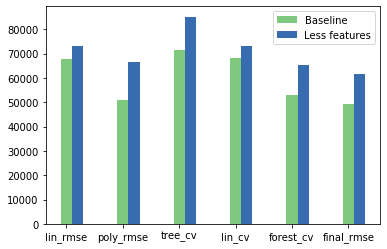

In [37]:
baseline = {"lin_rmse": 67912.11389345869, 
                   "poly_rmse": 50845.991750972935, 
                   "tree_cv": 71398.43250937833, 
                   "lin_cv": 68193.13973080671, 
                   "forest_cv": 52833.36700903783, 
                   "final_rmse": 49109.221590658875
                  }
less_features = {"lin_rmse": 73093.17, 
                   "poly_rmse": 66716.81, 
                   "tree_cv": 85124.76, 
                   "lin_cv": 73121.47, 
                   "forest_cv": 65498.23, 
                   "final_rmse": 61577.52
                  }

X = np.arange(len(baseline))
ax = plt.subplot(111)
ax.bar(X, baseline.values(), width=0.2, align='center', color=cm.Accent(0))
ax.bar(X+0.2, less_features.values(), width=0.2, align='center', color=cm.Accent(0.5))
ax.legend(('Baseline','Less features'))
plt.xticks(X, baseline.keys())
plt.show()

So in all cases the dropped features resulted in higher accuracy error when cross validation threshold was 0.1. Choosing a smaller threshold of 0.05 we get:

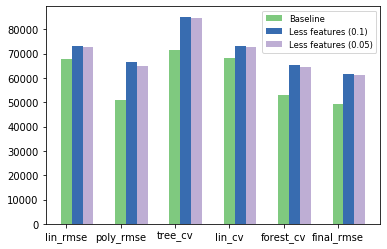

In [35]:
less_features2 = {"lin_rmse": 72528.01, 
                   "poly_rmse": 65024.48, 
                   "tree_cv": 84517.32, 
                   "lin_cv": 72561.17, 
                   "forest_cv": 64665.28, 
                   "final_rmse": 61309.45
                  }

X = np.arange(len(baseline))
ax = plt.subplot(111)
ax.bar(X, baseline.values(), width=0.2, align='center', color=cm.Accent(0))
ax.bar(X+0.2, less_features.values(), width=0.2, align='center', color=cm.Accent(0.5))
ax.bar(X+0.4, less_features2.values(), width=0.2, align='center', color=cm.Accent(1))
ax.legend(('Baseline','Less features (0.1)', 'Less features (0.05)'), fontsize='small')
plt.xticks(X, baseline.keys())
plt.show()

This suggests that having less features does not help, especially when the features that were removed were the basis of derived features that were added to the original pipeline before prepropcessing (e.g. `households`, `total_bedrooms`).

## 2.2 Using alternative preprocessing options

### `SimpleImputer` strategies

Running `mean` strategy returns:
```
lin_mrse on training set: 68000.42895660167
lin_mrse on training set with polynomial features 50822.21020303031
mrse on training set with decision tree regressor 0.0
cv mean on decision tree 70998.06072906117
cv mean on linear regression 68290.89012364062
cv mean on random forest 52763.53415107423
rmse on random forest grid search 48711.22322837824
```

`most_frequent`:
```
lin_mrse on training set: 67815.59017745727
lin_mrse on training set with polynomial features 50903.48056700182
mrse on training set with decision tree regressor 0.0
cv mean on decision tree 71901.68563614726
cv mean on linear regression 68116.87076630608
cv mean on random forest 52842.73097528787
rmse on random forest grid search 48774.06861384708
```

Plotting this gives

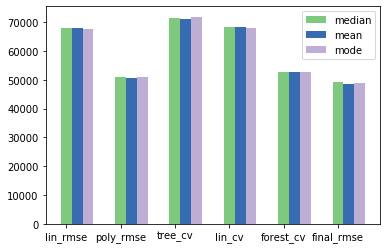

In [40]:
mean_strategy = {"lin_rmse": 68000.42895660167, 
                   "poly_rmse": 50822.21020303031, 
                   "tree_cv": 70998.06072906117, 
                   "lin_cv": 68290.89012364062, 
                   "forest_cv": 52763.53415107423, 
                   "final_rmse": 48711.22322837824
                  }
mode_strategy = {"lin_rmse": 67815.59017745727, 
                   "poly_rmse": 50903.48056700182, 
                   "tree_cv": 71901.68563614726, 
                   "lin_cv": 68116.87076630608, 
                   "forest_cv": 52842.73097528787, 
                   "final_rmse": 48774.06861384708
                  }

X = np.arange(len(baseline))
ax = plt.subplot(111)
ax.bar(X, baseline.values(), width=0.2, align='center', color=cm.Accent(0))
ax.bar(X+0.2, mean_strategy.values(), width=0.2, align='center', color=cm.Accent(0.5))
ax.bar(X+0.4, mode_strategy.values(), width=0.2, align='center', color=cm.Accent(1))
ax.legend(('median', 'mean', 'mode'))
plt.xticks(X, baseline.keys())
plt.show()

So the imputer strategy does not seem to affect much.

### Scaling strategies

The following plot compares the `StandardScaler`, `MinMaxScaler`, and no scaler.

In [ ]:
min_max_scaler = {"lin_rmse": 67912.11389345869, 
                   "poly_rmse": 50845.99150820819, 
                   "tree_cv": 71560.08913430922, 
                   "lin_cv": 68190.2754746336, 
                   "forest_cv": 52696.00120067185, 
                   "final_rmse": 48617.70748971388
                  }

no_scaler = {
    
    
    
}

# Task 3: Bike sharing dataset